# Implementing Logistic Regression
In this assignment, we will implement logistic regression.

In the module, we defined data as follows.

* N data points:  x<sub>i</sub>  for  i=1,2,....N 
* Each data has D dimensions:  x<sub>i</sub>=[x<sub>i1</sub>x<sub>i2</sub>…x<sub>iD</sub>]∈ℝ<sup>1×D </sup>
* Each data has a corresponding class label:  y<sub>i</sub>  = 0 or 1

Let's say

* N=2000 ,  D=2 
* for  i  = 1, ..., 1000, we use np.random.randn(N, 2) + np.array([0.9, 0.9]) as  x<sub>i</sub> , and  y<sub>i</sub>=0 
* for  i  = 1001, ..., 2000, we use  np.random.randn(N, 2) + np.array([-0.9, -0.9]) as  x<sub>i</sub> , and  y<sub>i</sub>=1 .
Yes, it's two 2D Gaussians centered in different points.

Task: Implement logistic regression using the setting above.

The following class is prepared for you to help implementation. (But you don't have to use it if you do not like it.)

In [1]:
import numpy as np

class Two2dGaussianData(object):
    '''
    Dataset of two 2d gaussian as a toy binary classification
    '''
    def __init__(self):
        '''
        initialize data with 2000 data points for training, 
        200 data points for validiation, 200 data points for test 
        '''
        N = 2000
        x0 = np.random.randn(N, 2) + np.array([0.9, 0.9])
        x1 = np.random.randn(N, 2) + np.array([-0.9, -0.9])
        self.X = {}
        self.X["train"]=np.vstack((x0[0:800], x1[1000:1800]))
        self.X["val"]=np.vstack((x0[800:900], x1[1800:1900]))
        self.X["test"]=np.vstack((x0[900:1000], x1[1900:2000]))
        y0=np.zeros(N).astype(np.int)
        y1=np.ones(N).astype(np.int)
        self.y={}
        self.y["train"]=np.hstack((y0[0:800], y1[1000:1800]))
        self.y["val"]=np.hstack((y0[800:900], y1[1800:1900]))
        self.y["test"]=np.hstack((y0[900:1000], y1[1900:2000]))
        
    def get_batch(self,batch_size,mode="train"):
        #get random batch
        num_all_data=len(self.X[mode])
        random_indices=np.random.choice(num_all_data, batch_size, replace=False)
        Xbatch=self.X[mode][random_indices]
        ybatch=self.y[mode][random_indices]

        return Xbatch,ybatch

In [2]:
#train set
dataset = Two2dGaussianData()
X = dataset.X["train"]
y=dataset.y["train"]
dfy = pd.DataFrame(y)
import pandas as pd
dfx = pd.DataFrame(X)
dfxy = pd.concat([dfx, dfy], axis=1)
dfxy.columns = ["x0", "x1", "y"]

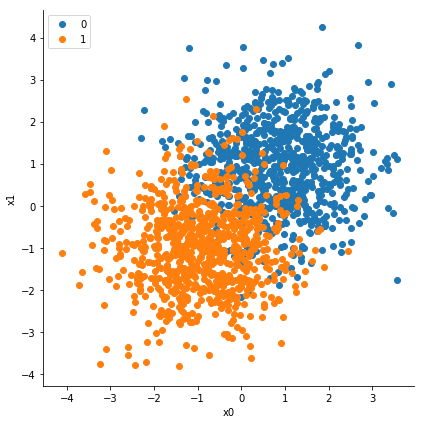

In [20]:
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline
xyplot=sb.FacetGrid(dfxy,hue = "y", size=6).map(plt.scatter, "x0", "x1")
plt.legend(loc='upper left')

In [21]:
#validation set
Xval = dataset.X["val"]
yval = dataset.y["val"]
dfyval = pd.DataFrame(yval)
dfxval = pd.DataFrame(Xval)
dfxyval = pd.concat([dfxval, dfyval], axis=1)
dfxyval.columns = ["x0", "x1", "y"]

In [22]:
#test set
Xtst = dataset.X["test"]
ytst = dataset.y["test"]
dfytst = pd.DataFrame(ytst)
dfxtst = pd.DataFrame(Xtst)
dfxytst = pd.concat([dfxtst, dfytst], axis=1)
dfxytst.columns = ["x0", "x1", "y"]

In [27]:
#Train Data setup

cls = [0, 1]
#Number of examples
m = dfxy.shape[0]
#Features
n = 2
#Number of classes
k = 2

X = np.ones((m,n + 1))
y = np.array((m,1))
X[:,1] = dfxy['x0'].values
X[:,2] = dfxy['x1'].values

#Labels
y = dfxy['y'].values

#Mean normalization
for j in range(n):
    X[:, j] = (X[:, j] - X[:,j].mean())
    
X_train = X
y_train = y

In [36]:
#Test Data setup

cls = [0, 1]
#Number of examples
m = dfxytst.shape[0]
#Features
n = 2
#Number of classes
k = 2

X = np.ones((m,n + 1))
y = np.array((m,1))
X[:,1] = dfxytst['x0'].values
X[:,2] = dfxytst['x1'].values

#Labels
y = dfxytst['y'].values

#Mean normalization
for j in range(n):
    X[:, j] = (X[:, j] - X[:,j].mean())
    
X_test = X
y_test = y

In [37]:

def sigmoid(z):
    return 1.0 / (1+np.exp(-z))

#Regularized cost function
def regCostFunction(theta, X, y, _lambda = 0.1):
    m = len(y)
    h = sigmoid(X.dot(theta))
    reg = (_lambda/(2*m)) * np.sum(theta**2)
    
    return (1/m) * (-y.T.dot(np.log(h)) - (1-y).T.dot(np.log(1-h))) + reg

#Reg gradient function
def regGradient(theta, X, y, _lambda = 0.1):
    m, n = X.shape
    theta = theta.reshape((n, 1))
    y = y.reshape((m, 1))
    h = sigmoid(X.dot(theta))
    reg = _lambda * theta /m

    return ((1 / m) * X.T.dot(h - y)) + reg

#Optimal theta 
def logisticRegression(X, y, theta):
    result = op.minimize(fun = regCostFunction, x0 = theta, args = (X, y),
                         method = 'TNC', jac = regGradient)
    
    return result.x

In [38]:
from scipy import optimize as op
#Training

all_theta = np.zeros((k, n + 1))

#One vs all
i = 0
for coor in cls:
    #set the labels in 0 and 1
    tmp_y = np.array(y_train == coor, dtype = int)
    optTheta = logisticRegression(X_train, tmp_y, np.zeros((n + 1,1)))
    all_theta[i] = optTheta
    i += 1

In [40]:
from sklearn.metrics import accuracy_score  

#Predictions
P = sigmoid(X_test.dot(all_theta.T)) #probability for each flower
p = [cls[np.argmax(P[i, :])] for i in range(X_test.shape[0])]

print("Test Accuracy ", accuracy_score(y_test, p) * 100 , '%')

Test Accuracy  90.0 %


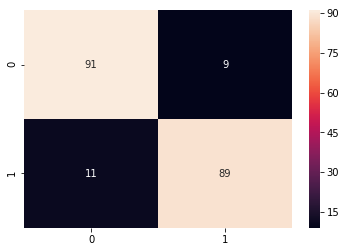

In [41]:
from sklearn.metrics import confusion_matrix #Confusion matrix

#Confusion Matrix
cfm = confusion_matrix(y_test, p, labels = cls)

sb.heatmap(cfm, annot = True, xticklabels = cls, yticklabels = cls);
